# High Resource Language: English

**First Model: facebook/wav2vec2-base-960h**

In [68]:
import os
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import soundfile as sf

# Load the pre-trained Wav2Vec2 model and processor
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Load the CSV file
file_path = "metadata.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Limit processing to the first 500 records
data = data.head(500)

# Define the folder containing audio files
audio_folder = "selected_wavs/selected_wavs"  # Replace with the correct path to your folder

# Generate full audio paths
data["audio_path"] = data["file_name"].apply(lambda x: os.path.join(audio_folder, x))

# Function to transcribe audio using Wav2Vec2
def transcribe_audio(audio_path):
    try:
        # Load audio file
        speech, rate = sf.read(audio_path)
        # Preprocess audio
        input_values = processor(speech, sampling_rate=rate, return_tensors="pt", padding=True).input_values
        # Perform inference
        logits = model(input_values).logits
        # Decode predicted IDs to text
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])
        # print(transcription.lower())
        return transcription.lower()
    except Exception as e:
        return f"Error: {e}"

# Create a new column 'predicted' with transcriptions for each audio file
data["predicted"] = data["audio_path"].apply(transcribe_audio)

# Save the updated DataFrame with the new 'predicted' column
output_file = "metadata_with_predictions_wav2vec2.csv"
data.to_csv(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Updated CSV saved to: metadata_with_predictions_wav2vec2.csv


**Word Error Rate Analysis of wav2vec2-base-960h model**

Updated dataset with WER saved to: metadata_with_wer.csv


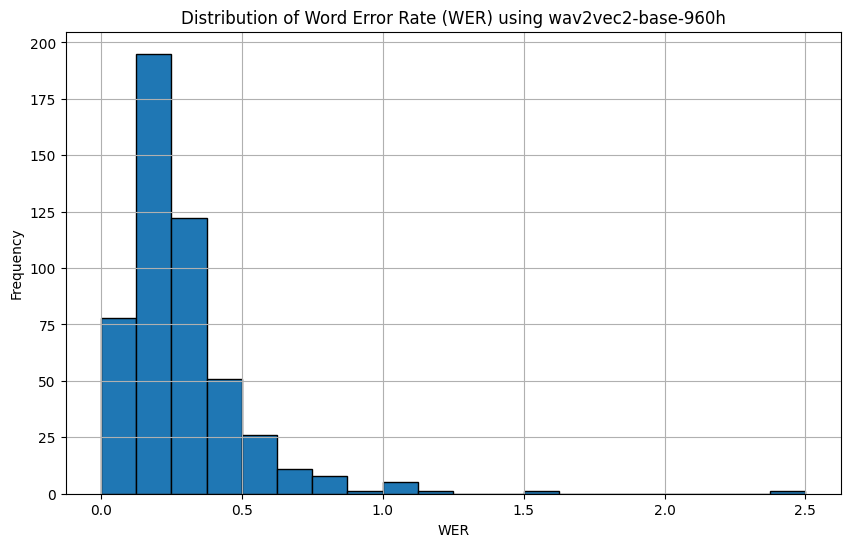

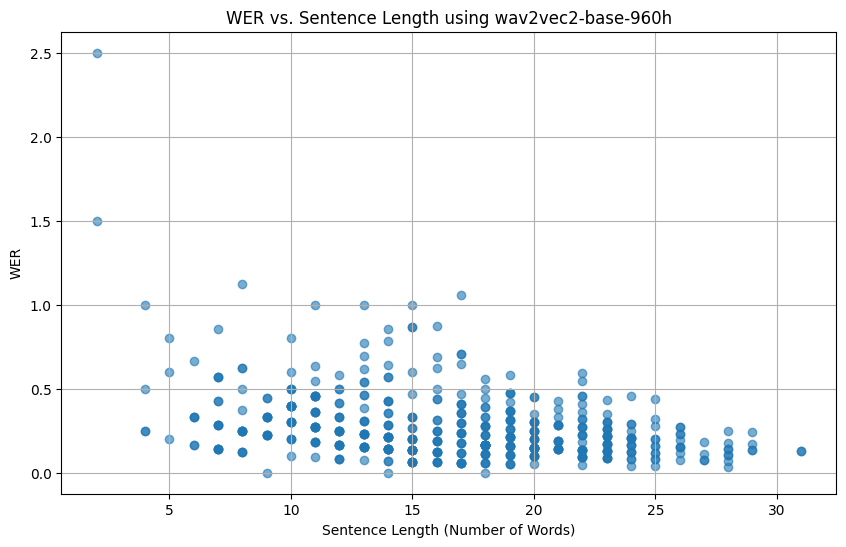

In [13]:
import pandas as pd
from jiwer import wer
import matplotlib.pyplot as plt

# Load the dataset with predicted transcriptions
file_path = "metadata_with_predictions_wav2vec2.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Calculate WER for each record
def calculate_wer(row):
    try:
        return wer(row["sentence"], row["predicted"])
    except Exception as e:
        return None

# Add WER as a new column
data["WER"] = data.apply(calculate_wer, axis=1)

# Save the updated dataset with WER
output_file = "metadata_with_wer.csv"
data.to_csv(output_file, index=False)
print(f"Updated dataset with WER saved to: {output_file}")

# Visualize WER: Distribution of WER
plt.figure(figsize=(10, 6))
plt.hist(data["WER"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Word Error Rate (WER) using wav2vec2-base-960h")
plt.xlabel("WER")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualize WER: WER vs Sentence Length
data["sentence_length"] = data["sentence"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(data["sentence_length"], data["WER"], alpha=0.6)
plt.title("WER vs. Sentence Length using wav2vec2-base-960h")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("WER")
plt.grid()
plt.show()


**Second Model: microsoft/speecht5_asr**

In [3]:
import os
import pandas as pd
import torch
import soundfile as sf
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText

# Load the SpeechT5 processor and model
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

# Load the CSV file
file_path = "metadata.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Limit processing to the first 500 records
data = data.head(500)

# Define the folder containing audio files
audio_folder = "selected_wavs/selected_wavs"  # Replace with the correct path to your folder

# Generate full audio paths
data["audio_path"] = data["file_name"].apply(lambda x: os.path.join(audio_folder, x))

# Function to transcribe audio using SpeechT5
def transcribe_audio(audio_path):
    try:
        # Load audio file
        speech, rate = sf.read(audio_path)
        # Preprocess audio for the SpeechT5 model
        inputs = processor(audio=speech, sampling_rate=rate, return_tensors="pt", padding=True)
        
        # Perform inference
        with torch.no_grad():
            generated_ids = model.generate(input_values=inputs["input_values"].to(model.device))
            predicted_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            # print(predicted_text.lower())
            
        return predicted_text.lower()  # Return the predicted text in lowercase
    except Exception as e:
        return f"Error: {e}"

# Create a new column 'predicted' with transcriptions for each audio file
data["predicted"] = data["audio_path"].apply(transcribe_audio)

# Save the updated DataFrame with the new 'predicted' column
output_file = "metadata_with_predictions_speecht5.csv"
data.to_csv(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


Some weights of SpeechT5ForSpeechToText were not initialized from the model checkpoint at microsoft/speecht5_asr and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Updated CSV saved to: metadata_with_predictions_speecht5.csv


**Word Error Rate Analysis of speecht5_asr model**

Updated dataset with WER saved to: metadata_with_wer.csv


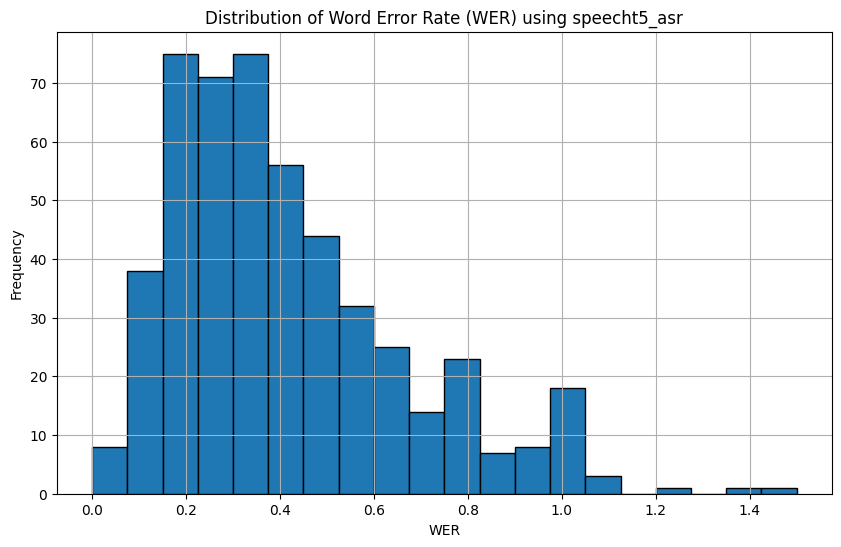

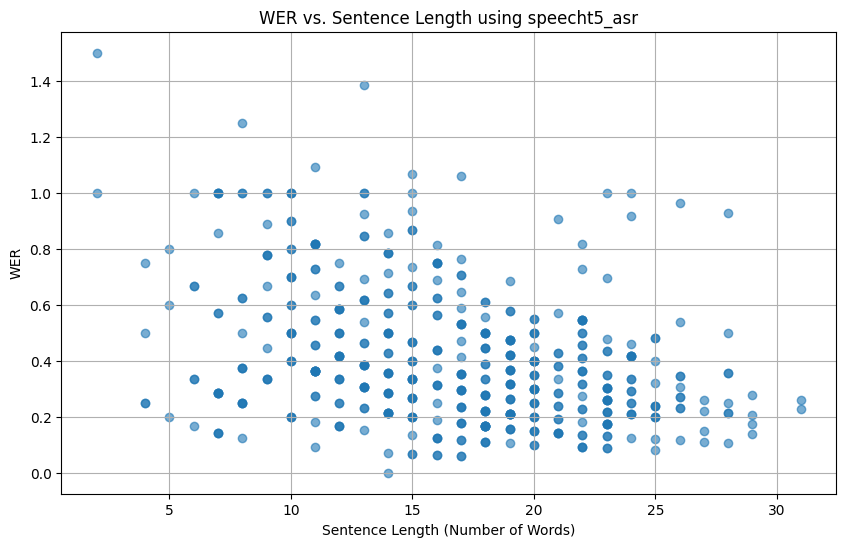

In [14]:
import pandas as pd
from jiwer import wer
import matplotlib.pyplot as plt

# Load the dataset with predicted transcriptions
file_path = "metadata_with_predictions_speecht5.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Calculate WER for each record
def calculate_wer(row):
    try:
        return wer(row["sentence"], row["predicted"])
    except Exception as e:
        return None

# Add WER as a new column
data["WER"] = data.apply(calculate_wer, axis=1)

# Save the updated dataset with WER
output_file = "metadata_with_wer.csv"
data.to_csv(output_file, index=False)
print(f"Updated dataset with WER saved to: {output_file}")

# Visualize WER: Distribution of WER
plt.figure(figsize=(10, 6))
plt.hist(data["WER"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Word Error Rate (WER) using speecht5_asr")
plt.xlabel("WER")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualize WER: WER vs Sentence Length
data["sentence_length"] = data["sentence"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(data["sentence_length"], data["WER"], alpha=0.6)
plt.title("WER vs. Sentence Length using speecht5_asr")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("WER")
plt.grid()
plt.show()


# Low Resource Langugae:Punjabi

**First Model:wav2vec2-large-xlsr-punjabi**

In [5]:
import os
import pandas as pd
import torch
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import librosa

# Load the Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("manandey/wav2vec2-large-xlsr-punjabi")
model = Wav2Vec2ForCTC.from_pretrained("manandey/wav2vec2-large-xlsr-punjabi")
model = model.to("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Load the Excel file
file_path = "train.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Limit processing to the first 500 records
data = data.head(500)

# Define the folder containing audio files
audio_folder = "clips/clips"  # Replace with the correct path to your folder

# Clean all spaces from the 'id' column
data["id"] = data["id"].str.strip()

# Generate full audio paths by appending ".wav" to the IDs
data["audio_path"] = data["id"].apply(lambda x: os.path.join(audio_folder, f"{x}.wav"))

# Verify the updated DataFrame
# print("Sample data with audio paths:")
# print(data.head(5))

# Function to resample audio to 16 kHz if needed
def resample_audio(audio_path):
    try:
        # Load the audio file
        audio, original_rate = sf.read(audio_path)

        # Resample only if the rate is not 16 kHz
        if original_rate != 16000:
            # print(f"Resampling {audio_path} from {original_rate} Hz to 16 kHz.")
            audio = librosa.resample(audio, orig_sr=original_rate, target_sr=16000)
            return audio, 16000
        return audio, original_rate
    except Exception as e:
        raise ValueError(f"Error processing {audio_path}: {e}")

# Function to transcribe audio using Wav2Vec2
def transcribe_audio(audio_path):
    try:
        # Check if the file exists
        if not os.path.exists(audio_path):
            return f"Error: File not found - {audio_path}"

        # Load and resample audio if needed
        speech, rate = resample_audio(audio_path)

        # Preprocess audio for the Wav2Vec2 model
        inputs = processor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
        inputs = {key: value.to(model.device) for key, value in inputs.items()}  # Move to the correct device

        # Perform inference
        with torch.no_grad():
            # logits = model(inputs.input_values).logits
            logits = model(inputs["input_values"]).logits 

        # Decode the output to text
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])
        # print(f"Transcribed: {transcription}")

        return transcription  # Return the transcription in lowercase
    except Exception as e:
        return f"Error: {e}"

# Create a new column 'predicted' with transcriptions for each audio file
data["predicted"] = data["audio_path"].apply(transcribe_audio)

# Save the updated DataFrame with the new 'predicted' column
output_file = "metadata_with_predictions_punjabi.xlsx"
data.to_excel(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


C:\Users\Himani\M.tech\Speech understanding\assignmnet_1\test_env\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Himani\.cache\huggingface\hub\models--manandey--wav2vec2-large-xlsr-punjabi. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Himani\M.tech\Speech understanding\assignmnet_1\test_env

Updated CSV saved to: metadata_with_predictions_punjabi.xlsx


**Word Error Rate Analysis of :wav2vec2-large-xlsr-punjabi model**

Updated dataset with WER saved to: metadata_with_wer.csv


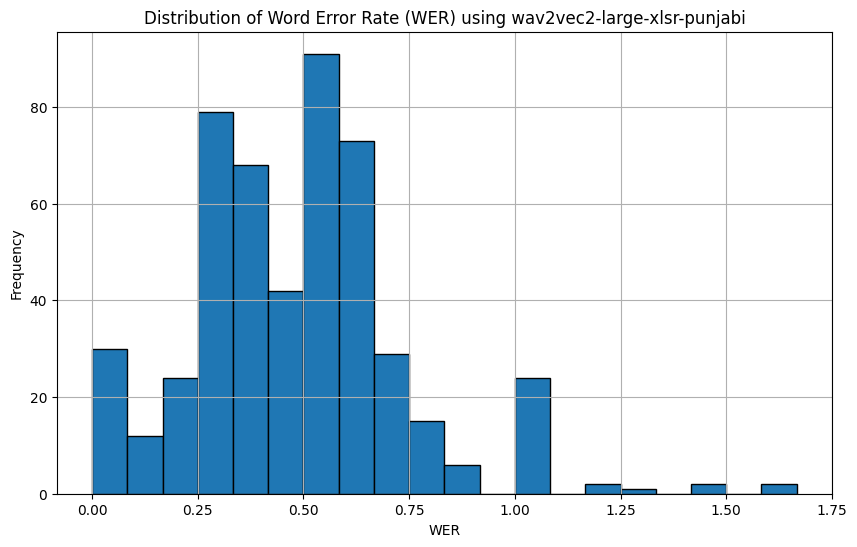

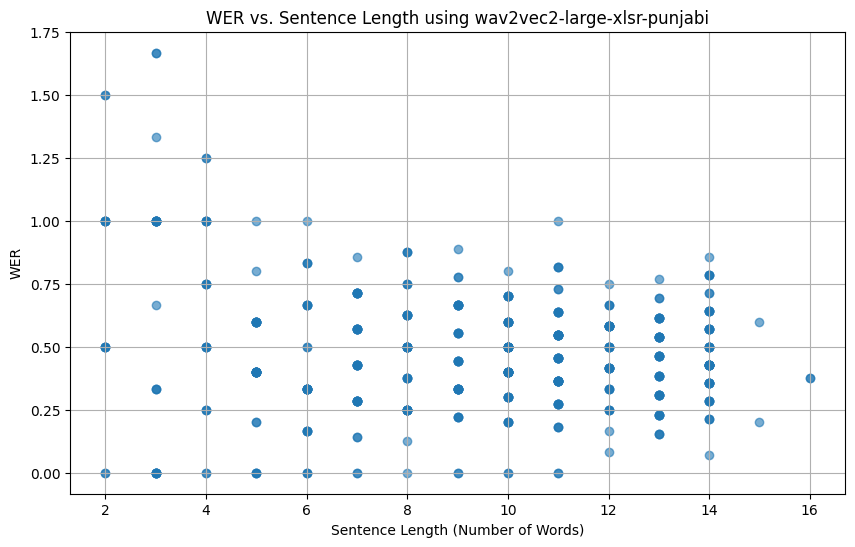

In [15]:
import pandas as pd
from jiwer import wer
import matplotlib.pyplot as plt

# Load the dataset with predicted transcriptions
file_path = "metadata_with_predictions_punjabi.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate WER for each record
def calculate_wer(row):
    try:
        return wer(row["sentence"], row["predicted"])
    except Exception as e:
        return None

# Add WER as a new column
data["WER"] = data.apply(calculate_wer, axis=1)

# Save the updated dataset with WER
output_file = "metadata_with_wer.csv"
data.to_csv(output_file, index=False)
print(f"Updated dataset with WER saved to: {output_file}")

# Visualize WER: Distribution of WER
plt.figure(figsize=(10, 6))
plt.hist(data["WER"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Word Error Rate (WER) using wav2vec2-large-xlsr-punjabi")
plt.xlabel("WER")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualize WER: WER vs Sentence Length
data["sentence_length"] = data["sentence"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(data["sentence_length"], data["WER"], alpha=0.6)
plt.title("WER vs. Sentence Length using wav2vec2-large-xlsr-punjabi")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("WER")
plt.grid()
plt.show()


**Second Model:whisper**

In [9]:
import whisper
from indic_transliteration.sanscript import transliterate
import pandas as pd
import os

# Load the Whisper model
model = whisper.load_model("base")

# Define input and output Excel files
input_excel = "train.xlsx"  # Path to the input Excel file
output_excel = "translated_output.xlsx"  # Path to save the output Excel file

# Define the folder containing audio files
audio_folder = "clips\\clips"  # Replace with the correct folder path

# Load the Excel file
data = pd.read_excel(input_excel)


data = data.head(500)

# Clean and ensure 'id' column is properly formatted
data["id"] = data["id"].str.strip()

# Generate full audio paths by appending ".wav" to the IDs
data["audio_path"] = data["id"].apply(lambda x: os.path.join(audio_folder, f"{x}.wav"))

# Function to transcribe audio and transliterate to Punjabi
def process_audio(audio_path):
    try:
        # Check if the file exists
        # print(audio_path)
        if not os.path.exists(audio_path):
            return {"transcription": "Error: File not found", "translation": ""}
        
        # Transcribe using Whisper
        result = model.transcribe(audio_path)
        english_text = result["text"]

        # Transliterate to Punjabi
        punjabi_text = transliterate(english_text, 'itrans', 'gurmukhi')

        # print(punjabi_text)
        return punjabi_text
    except Exception as e:
        return {"transcription": f"Error: {e}", "translation": ""}

# Process each audio file and store the results
# data["transcription"] = data["audio_path"].apply(lambda path: process_audio(path)["transcription"])
# data["translation"] = data["audio_path"].apply(lambda path: process_audio(path)["translation"])
data["predicted"] = data["audio_path"].apply(process_audio)
# Save the updated DataFrame with transcriptions and translations
data.to_excel(output_excel, index=False)

print(f"Output saved to: {output_excel}")


C:\Users\Himani\M.tech\Speech understanding\assignmnet_1\test_env\lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

Output saved to: translated_output.xlsx


**Word Error Rate Analysis of whisper model**

Updated dataset with WER saved to: metadata_with_wer.csv


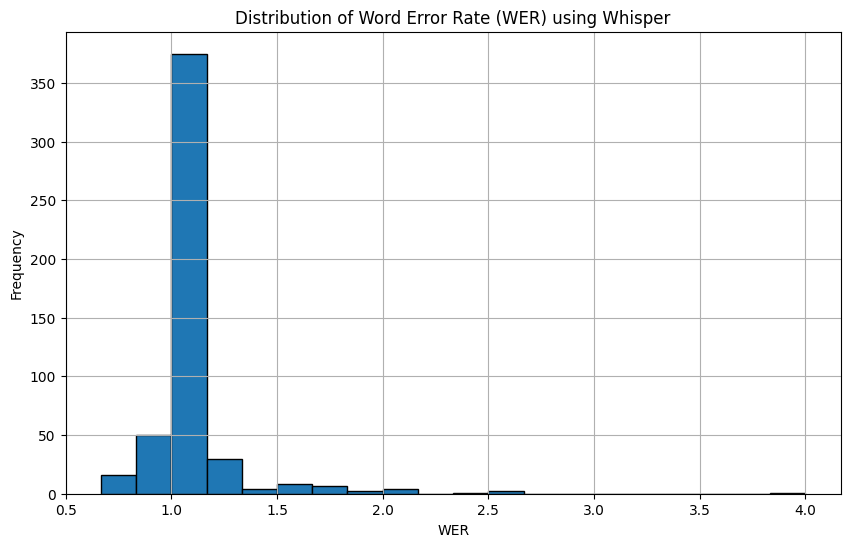

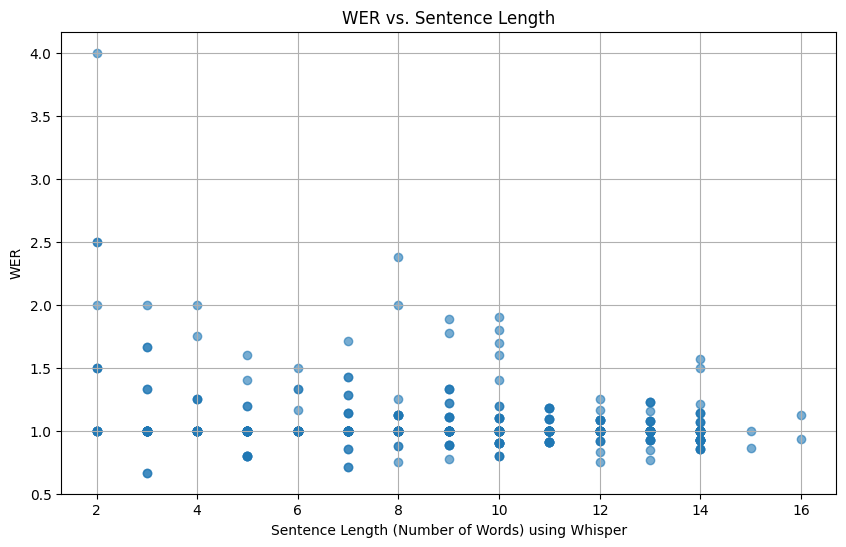

In [16]:
import pandas as pd
from jiwer import wer
import matplotlib.pyplot as plt

# Load the dataset with predicted transcriptions
file_path = "translated_output.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Calculate WER for each record
def calculate_wer(row):
    try:
        return wer(row["sentence"], row["predicted"])
    except Exception as e:
        return None

# Add WER as a new column
data["WER"] = data.apply(calculate_wer, axis=1)

# Save the updated dataset with WER
output_file = "metadata_with_wer.csv"
data.to_csv(output_file, index=False)
print(f"Updated dataset with WER saved to: {output_file}")

# Visualize WER: Distribution of WER
plt.figure(figsize=(10, 6))
plt.hist(data["WER"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Word Error Rate (WER) using Whisper")
plt.xlabel("WER")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualize WER: WER vs Sentence Length
data["sentence_length"] = data["sentence"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(data["sentence_length"], data["WER"], alpha=0.6)
plt.title("WER vs. Sentence Length")
plt.xlabel("Sentence Length (Number of Words) using Whisper")
plt.ylabel("WER")
plt.grid()
plt.show()
